<a href="https://colab.research.google.com/github/Deepanshu99589/COLAB/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mini Project to predict the time taken to solve a problem given the current status of the user.**

**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
from pandas import Grouper

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn as sns
sns.set_style("whitegrid")

from scipy import stats
from math import sqrt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


import warnings
warnings.filterwarnings('ignore')

**Read and split the data**

In [ ]:
df = pd.read_csv('Electric_Production.csv', header=0, index_col=0, parse_dates=True)
split_point = len(df) - 12*3
train, test = df[0:split_point], df[split_point:]
print('train %d, test %d' % (len(train), len(test)))

train 361, test 36


**Visualise the data**

In [ ]:
train.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
train.shape

(361, 1)

In [ ]:
train.describe()

,Value
count,361.000000
mean,87.451703
std,15.123678
min,55.315100
25%,75.682600
50%,88.041000
75%,99.115500
max,124.254900


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1985-01-01 to 2015-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


In [ ]:
train.isnull().sum()

Value    0
dtype: int64

**Data visualization**

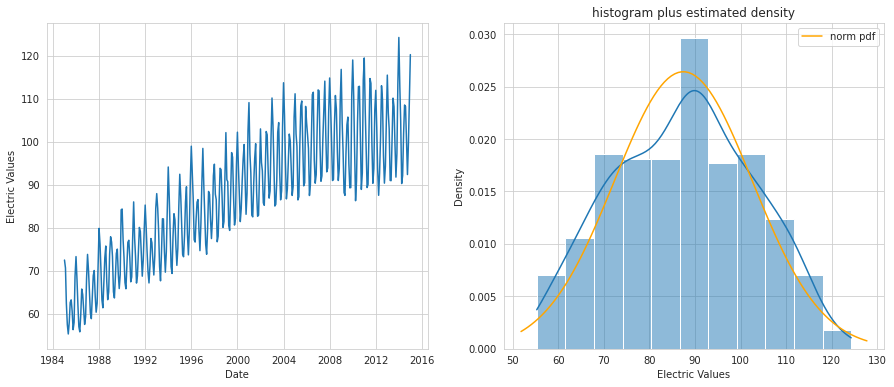

In [ ]:
fig,axes =plt.subplots(1,2)
# time series line plot on the
axes[0].plot(train['Value'])
axes[0].set(xlabel='Date',ylabel='Electric Values')

# histogram plot
sns.histplot(train['Value'], ax=axes[1], stat='density', kde=True)
axes[1].set(title='histogram plus estimated density', xlabel='Electric Values')

# plot corresponding normal curve
mu, std = stats.norm.fit(train['Value'])
xmin, xmax=plt.xlim() # the maximum x values from the histogram above
x=np.linspace(xmin, xmax, 100)
p=stats.norm.pdf(x, mu, std) #calculate the y values for the normal curve
axes[1].plot(x, p, color='orange',label='norm pdf')
axes[1].legend(loc='best')
plt.show()

* There looks to be an increasing trend in electric values over time, and there may be a downward trend for the recent few years.

* There appears to be systematic seasonality to electric values for each year, which suggests that the electric values is almost certainly non-stationary

* The seasonal signal appears to have an increasing variance from year to year over time.

We can explore the difference with one year lag to make the series of electric values stationary. The increasing variance in the seasonal component may suggest the use of a log or other power transform.

The distribution is pretty close to Gaussian.

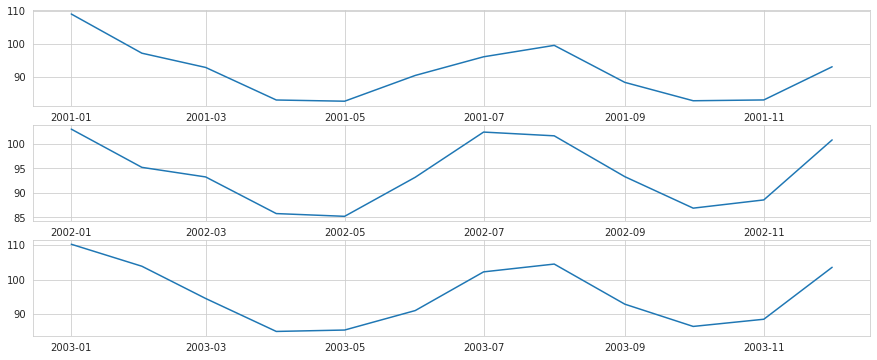

In [ ]:
# Create the stack of 5 line plots from 2000 to 2004 to see the seasonality and contrast the data for each year.
groups = train['Value']['2001':'2003'].groupby(Grouper(freq='A')) # calendar year end
i = 1
n = len(groups)
rcParams['figure.figsize'] = 15, 6
for name, group in groups:
    plt.subplot((n*100) + 10 + i)
    i += 1
    plt.plot(group)
plt.show()

It is clear to see a dip each April and October, a rise each August and December. This pattern appears the same each year, although at different levels. The dataset shows a strong seasonality component.

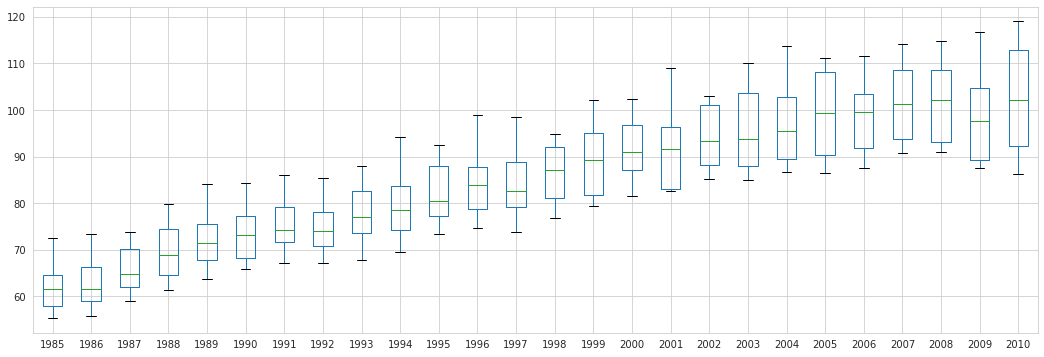

In [ ]:
# Creates multiple box and whisker plots
groups = train['Value']['1985':'2010'].groupby(Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
plt.figure(figsize=(18,6))
years.boxplot()
plt.show()

The median values for each year (green line) show an increasing trend at the first 15 years, then the increasing trend is slow at the next 10 years.

Compared to the next few years, the spread or middle 50% of the data (blue boxes) in previous years shows relatively small variability and tightly clusters together.

No Outliers each year (out of black lines).

**Transform Data**

In [ ]:
transformed, lam = stats.boxcox(train['Value'].values)
print('Lambda: %f' % lam)

Lambda: 0.938554


**Decomposition**

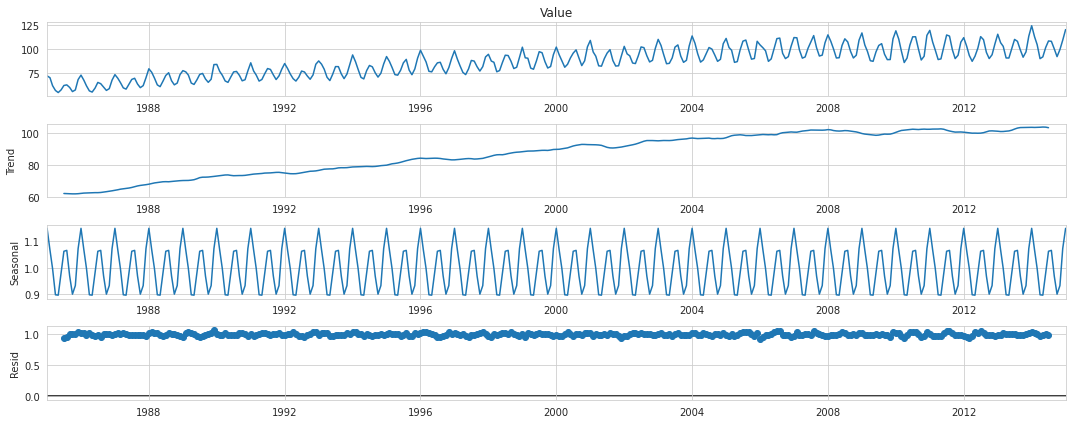

In [ ]:
decomposed1 = seasonal_decompose(train['Value'], model='multiplicative')
decomposed1.plot()
plt.show()

We apply a multiplicative decomposition model. The plot shows the observed series with a smoothed trend line, a seasonal pattern. But, let's look at the residuals, They are now centered around 1 and have a much lower range and standard deviation. The multiplicative decomposition model is incorrect.

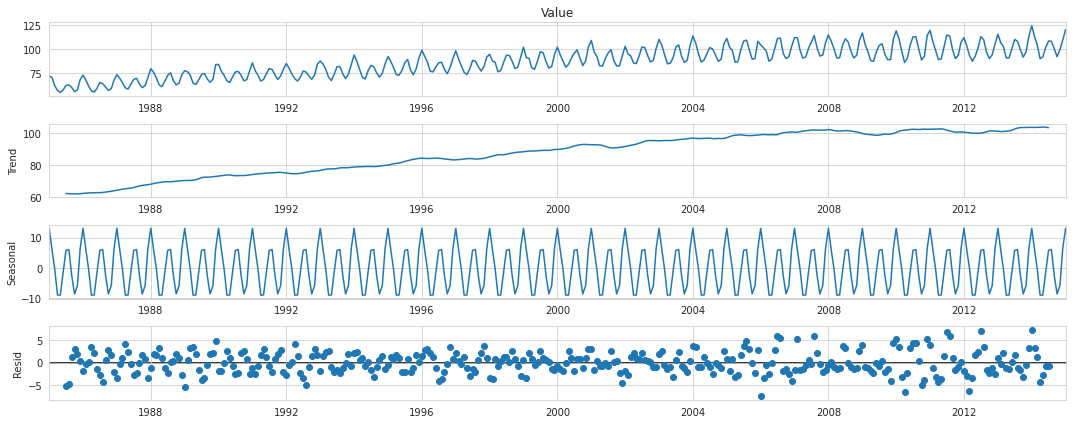

In [ ]:
decomposed = seasonal_decompose(train['Value'], model='additive')
decomposed.plot()
plt.show()

We apply an additive decomposition model. The plot shows the observed series with a smoothed trend line, a seasonal pattern and random part. Both trend and seasonal components were captured. The trend is always going up, and the seasonal component looks like it should. The residuals are centered around zero and normally distributed, and no distinct pattern in the residuals.

Stationarity

In [ ]:
def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Statistic', 'p-value', '#lags uesd', 'Number of Observations Used']
    for value, labels in zip(result, labels):
        print(labels+':'+str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root. It is non stationarity')

In [ ]:
adfuller_test(train['Value'])

ADF Statistic:-2.2020260906818803
p-value:0.20551092482251504
#lags uesd:15
Number of Observations Used:345
Weak evidence against null hypothesis, time series has a unit root. It is non stationarity


**Differencing**

In [ ]:
train['Seasonal First Difference']=train['Value']-train['Value'].shift(12)
train.head(13)

,Value,Seasonal First Difference
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN
1985-06-01,58.0904,NaN
1985-07-01,62.6202,NaN
1985-08-01,63.2485,NaN
1985-09-01,60.5846,NaN


In [ ]:
adfuller_test(train['Seasonal First Difference'].dropna())

ADF Statistic:-5.8698105954853546
p-value:3.2602771620873273e-07
#lags uesd:12
Number of Observations Used:336
Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary


**ACF & PACF**

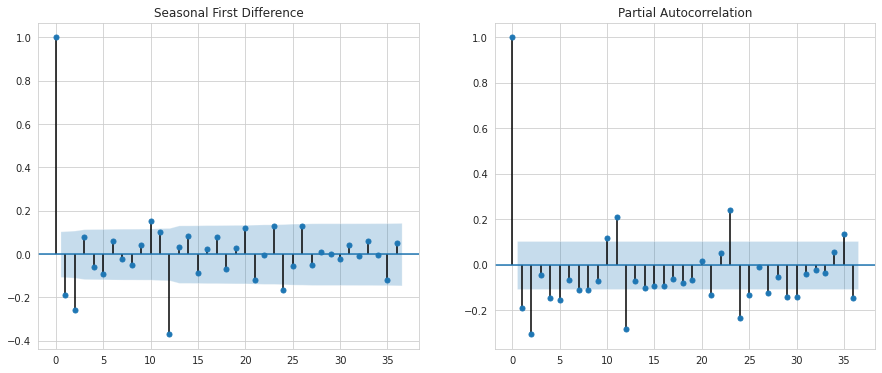

In [ ]:
plt.figure()
plt.subplot(121)
plot_acf(train['Seasonal First Difference'].diff().dropna(), lags=36, ax=plt.gca())
plt.title('Seasonal First Difference', fontsize=12)

plt.subplot(122)
plot_pacf(train['Seasonal First Difference'].diff().dropna(), lags=36, ax=plt.gca())
plt.show()

**Evaluate Baseline performance**

In [ ]:
history = [x for x in train['Value']]
predictions = []
for i in range(len(test)):
    # predict in the persistence model generated from the previous time
    yhat = history[-1]
    predictions.append(yhat)
    # observations added into the training set
    obs = test['Value'][i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test['Value'], predictions))
print('RMSE: %.3f' % rmse)

>Predicted=120.270, Expected=116.379
>Predicted=116.379, Expected=104.471
>Predicted=104.471, Expected=89.746
>Predicted=89.746, Expected=91.093
>Predicted=91.093, Expected=102.650
>Predicted=102.650, Expected=111.635
>Predicted=111.635, Expected=110.593
>Predicted=110.593, Expected=101.920
>Predicted=101.920, Expected=91.596
>Predicted=91.596, Expected=93.063
>Predicted=93.063, Expected=103.220
>Predicted=103.220, Expected=117.084
>Predicted=117.084, Expected=106.669
>Predicted=106.669, Expected=95.355
>Predicted=95.355, Expected=89.325
>Predicted=89.325, Expected=90.737
>Predicted=90.737, Expected=104.037
>Predicted=104.037, Expected=114.540
>Predicted=114.540, Expected=115.516
>Predicted=115.516, Expected=102.764
>Predicted=102.764, Expected=91.487
>Predicted=91.487, Expected=92.890
>Predicted=92.890, Expected=112.769
>Predicted=112.769, Expected=114.850
>Predicted=114.850, Expected=99.490
>Predicted=99.490, Expected=101.040
>Predicted=101.040, Expected=88.353
>Predicted=88.353, Exp

**Evaluate a manually configured SARIMA model**

In [ ]:
training_window=len(train['Value'])
history = [x for x in train['Value']]
history = history[(-training_window):] # fix training set window

predictions = []

order = (2,0,2)
seasonal_order =(0,1,1,12)

for i in range(len(test)):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    # predict
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    # move the training window
    obs = test['Value'][i]
    history.append(obs)
    history.pop(0)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test['Value'], predictions))
print('RMSE: %.3f' % rmse)

>Predicted=110.651, Expected=116.379
>Predicted=106.170, Expected=104.471
>Predicted=92.122, Expected=89.746
>Predicted=92.241, Expected=91.093
>Predicted=102.417, Expected=102.650
>Predicted=112.010, Expected=111.635
>Predicted=111.104, Expected=110.593
>Predicted=100.486, Expected=101.920
>Predicted=93.842, Expected=91.596
>Predicted=96.640, Expected=93.063
>Predicted=108.832, Expected=103.220
>Predicted=115.553, Expected=117.084
>Predicted=110.881, Expected=106.669
>Predicted=99.860, Expected=95.355
>Predicted=86.403, Expected=89.325
>Predicted=91.887, Expected=90.737
>Predicted=101.537, Expected=104.037
>Predicted=112.264, Expected=114.540
>Predicted=112.175, Expected=115.516
>Predicted=103.329, Expected=102.764
>Predicted=93.157, Expected=91.487
>Predicted=95.444, Expected=92.890
>Predicted=107.070, Expected=112.769
>Predicted=121.651, Expected=114.850
>Predicted=107.603, Expected=99.490
>Predicted=94.928, Expected=101.040
>Predicted=91.700, Expected=88.353
>Predicted=90.253, Expe

**Diagnose Residuals**

In [ ]:
residuals = [test['Value'][i]-predictions[i] for i in range(len(test['Value']))]
results_manual = pd.DataFrame({'Expected':test['Value'], 'Prediction':predictions,'Residuals':residuals}, index=test.index)
results_manual.head()

,Expected,Prediction,Residuals
DATE,,,
2015-02-01,116.3788,110.650578,5.728222
2015-03-01,104.4706,106.169672,-1.699072
2015-04-01,89.7461,92.121654,-2.375554
2015-05-01,91.0930,92.240852,-1.147852
2015-06-01,102.6495,102.417225,0.232275


In [ ]:
print(results_manual['Residuals'].describe())

count    36.000000
mean     -0.094813
std       3.740351
min      -8.113073
25%      -2.420217
50%      -0.538695
75%       2.332009
max       8.945642
Name: Residuals, dtype: float64


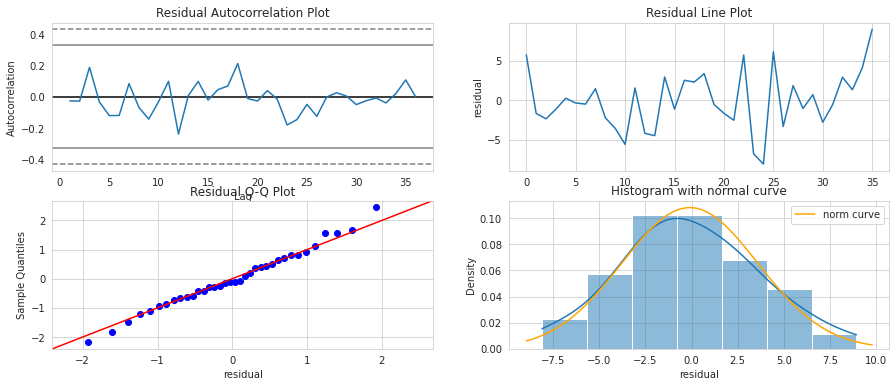

In [ ]:
fig,axes =plt.subplots(2,2)
# autocorrelation plot
pd.plotting.autocorrelation_plot(residuals, ax=axes[0,0])
axes[0,0].set(title='Residual Autocorrelation Plot')


# line plot
axes[0,1].plot(residuals)
axes[0,1].set(title='Residual Line Plot', ylabel='residual')


# Q-Q Plot
import statsmodels.api as sm
sm.qqplot(np.array(residuals),stats.t, fit=True, line="45", ax=axes[1,0])
axes[1,0].set(title='Residual Q-Q Plot', xlabel='residual')

# histogram plot with corresponding normal curve
sns.histplot(residuals, ax=axes[1,1], stat='density', kde=True)
axes[1,1].set(title='Histogram with normal curve', xlabel='residual')
# plot corresponding normal curve
xmin, xmax=plt.xlim() # the maximum x values from the histogram above
x=np.linspace(xmin, xmax, 100)
mu, std = stats.norm.fit(residuals)
p=stats.norm.pdf(x, mu, std) #calculate the y values for the normal curve
axes[1,1].plot(x, p, color='orange',label='norm curve')
axes[1,1].legend(loc='best')
plt.show()

**Determine start & max parameters and select the best model**

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
model_sarima= auto_arima(train['Value'],trace=True, error_action='ignore',
                         start_p=0,start_q=0,max_p=5,max_q=2,max_d=1,max_D=1,m=12,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima_fit = model_sarima.fit(train['Value'])
print(model_sarima_fit.summary())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.1 MB/s 
     |████████████████████████████████| 9.9 MB 39.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1727.540, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2475.522, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2150.119, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2473.634, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2201.298, Time=0.27 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1727.957, Time=2.40 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1727.166, Time=2.80 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2084.822, Time=1.16 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1727.150, Time=4.08 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=1718.473, Time=5.58 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1718.708, Time=3.43 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1719.346, Time=3.03 sec
 ARIMA(1,1,0)(1,0,1)[12] inte

**Diagnose Residuals**

<Figure size 720x720 with 0 Axes>

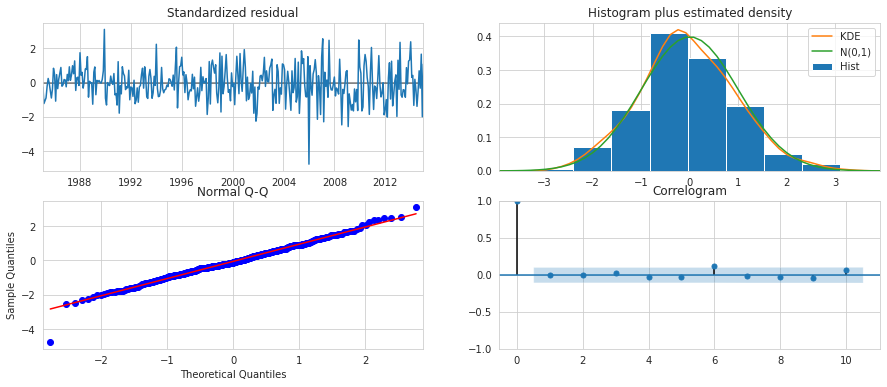

In [ ]:
plt.figure(figsize=(10,10))
# plot residual errors
residuals = pd.DataFrame(model_sarima_fit.resid())
model_sarima_fit.plot_diagnostics()
plt.show()

**Calculate RMSE on the test dataset**

In [ ]:
prediction_auto=model_sarima_fit.predict(len(test['Value']))
# errors
residuals_auto = [test['Value'][i]-prediction_auto[i] for i in range(len(test['Value']))]
results_auto = pd.DataFrame({'Expected':test['Value'], 'Prediction':prediction_auto,'Residuals':residuals_auto}, index=test.index)
results_auto.head()

,Expected,Prediction,Residuals
DATE,,,
2015-02-01,116.3788,111.023594,5.355206
2015-03-01,104.4706,102.660725,1.809875
2015-04-01,89.7461,91.547221,-1.801121
2015-05-01,91.0930,93.581856,-2.488856
2015-06-01,102.6495,103.438042,-0.788542


In [ ]:
RMSE_auto_optimal = sqrt(np.mean(np.square(residuals)))
print('The RMSE of the best SARIMA model =%.3f' % (RMSE_auto_optimal))

The RMSE of the best SARIMA model =4.486


**Compare RMSE**

In [ ]:
Compare_RMSE = pd.DataFrame({'RMSE':[10.018, 3.689,4.486]},
                            index=['persistence model','Manually configured model SARIMA(2,0,2)(0,1,1,12)','Automated selected model ARIMA(1,1,2)(2,0,2)[12]'])
Compare_RMSE

,RMSE
persistence model,10.018
"Manually configured model SARIMA(2,0,2)(0,1,1,12)",3.689
"Automated selected model ARIMA(1,1,2)(2,0,2)[12]",4.486


**Model forecast**

In [ ]:
def forecast(model,predict_steps):

    pred_uc = model.get_forecast(steps=predict_steps, dynamic=True)
    #print(pred_uc.__dict__)
    #print(dir(pred_uc))

    #SARIMAXResults.conf_int,the default alpha = .05 returns a 95% confidence interval.
    pred_mean = pred_uc.predicted_mean
    pred_ci = pred_uc.conf_int()

    index = pd.date_range('2018-02-01', '2020-1-01', freq='MS')
    prediction_table = pd.DataFrame({'Predicted_Mean':pred_mean,'Lower Bound':pred_ci[:,0],'Upper Bound':pred_ci[:,1]},
                                   index=index)
    return prediction_table

In [ ]:
prediction_table = forecast(model_fit,24)
prediction_table.head()

,Predicted_Mean,Lower Bound,Upper Bound
2018-02-01,120.459158,115.688658,125.229659
2018-03-01,108.801326,103.258685,114.343968
2018-04-01,101.525597,95.839579,107.211616
2018-05-01,90.410390,84.676368,96.144413
2018-06-01,92.412886,86.651542,98.174230


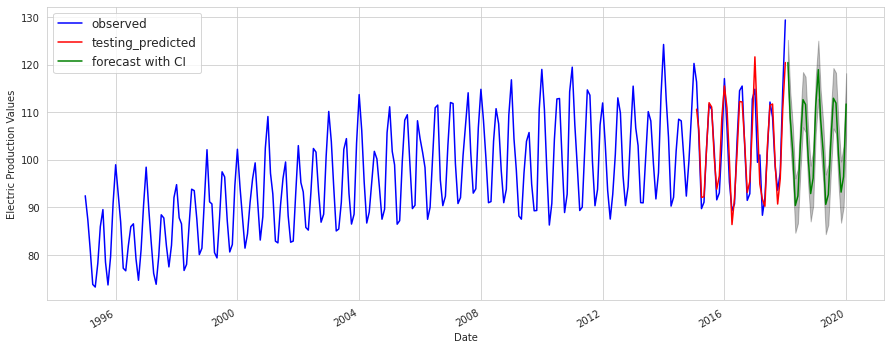

In [ ]:
plt.plot(df['Value'].loc['1995':], color = "blue", label='observed')
results_manual['Prediction'].plot(color = "red", label='testing_predicted')
prediction_table['Predicted_Mean'].plot(color = "green", label='forecast with CI')
plt.fill_between(prediction_table.index, prediction_table['Lower Bound'],prediction_table['Upper Bound'], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Electric Production Values')
plt.legend(loc='upper left', fontsize=12)
sns.set()
plt.show()